# Downloading Dataset

In [1]:
!pip install -q kaggle

In [2]:
# upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"imadedwipayana","key":"c997969937d91fea2916d65abe6bc451"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [4]:
!kaggle datasets download -d uciml/sms-spam-collection-dataset

  0% 0.00/211k [00:00<?, ?B/s]
100% 211k/211k [00:00<00:00, 51.1MB/s]


In [5]:
!mkdir dataset
!unzip sms-spam-collection-dataset.zip -d dataset
!ls dataset

Archive:  sms-spam-collection-dataset.zip
  inflating: dataset/spam.csv        
spam.csv


In [6]:
import pandas as pd
# load dataset
df = pd.read_csv('dataset/spam.csv', encoding='latin1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Manipulating and Normalize Dataset

In [7]:
df = df[['v1', 'v2']]
df[['v2', 'v1']] = df[['v1', 'v2']]
df = df.rename(columns = {'v1': 'text', 'v2': 'spams'}, inplace = False)

df.head()

,text,spams
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [8]:
category = pd.get_dummies(df.spams)
df_new = pd.concat([df, category], axis=1)
df_new = df_new.drop(columns='spams')

df_new.head()

,text,ham,spam
0,"Go until jurong point, crazy.. Available only ...",1,0
1,Ok lar... Joking wif u oni...,1,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,0,1
3,U dun say so early hor... U c already then say...,1,0
4,"Nah I don't think he goes to usf, he lives aro...",1,0


In [9]:
# turn text into lower-case
df_new.text = df_new.text.apply(lambda x: x.lower())

df_new

,text,ham,spam
0,"go until jurong point, crazy.. available only ...",1,0
1,ok lar... joking wif u oni...,1,0
2,free entry in 2 a wkly comp to win fa cup fina...,0,1
3,u dun say so early hor... u c already then say...,1,0
4,"nah i don't think he goes to usf, he lives aro...",1,0
...,...,...,...
5567,this is the 2nd time we have tried 2 contact u...,0,1
5568,will ì_ b going to esplanade fr home?,1,0
5569,"pity, * was in mood for that. so...any other s...",1,0
5570,the guy did some bitching but i acted like i'd...,1,0


In [10]:
text = df_new['text'].values
spams = df_new[['ham', 'spam']].values

# Modeling and Evaluation

In [11]:
from sklearn.model_selection import train_test_split
text_train, text_val, spams_train, spams_val = train_test_split(text, spams, test_size=0.2)

In [12]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
# tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(text_train) 
tokenizer.fit_on_texts(text_val)
 
seq_train = tokenizer.texts_to_sequences(text_train)
seq_val = tokenizer.texts_to_sequences(text_val)
 
padded_train = pad_sequences(seq_train) 
padded_val = pad_sequences(seq_val)

In [13]:
# sequentional model
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=5),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='softmax'),
    tf.keras.layers.Dense(2, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])



In [14]:
# making callback
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    def isNaN(num):
        return num != num
    if(logs.get('accuracy')>0.99 and logs.get('val_accuracy')>0.97):
      print("stop")
      self.model.stop_training = True
      
    if(isNaN(logs.get('loss')) == True):
      self.model.stop_training = True
      print("failed")

In [15]:
num_epochs = 1000
history = model.fit(padded_train, spams_train, epochs=num_epochs, 
                    validation_data=(padded_val, spams_val), verbose=2, callbacks=[Callback()])

Epoch 1/1000
140/140 - 13s - loss: 0.6151 - accuracy: 0.7772 - val_loss: 0.6120 - val_accuracy: 0.8744
Epoch 2/1000
140/140 - 11s - loss: 0.4730 - accuracy: 0.9668 - val_loss: 0.4219 - val_accuracy: 0.9417
Epoch 3/1000
140/140 - 10s - loss: 0.3863 - accuracy: 0.9843 - val_loss: 0.3571 - val_accuracy: 0.9543
Epoch 4/1000
140/140 - 11s - loss: 0.3243 - accuracy: 0.9901 - val_loss: 0.3409 - val_accuracy: 0.9229
Epoch 5/1000
140/140 - 11s - loss: 0.2783 - accuracy: 0.9939 - val_loss: 0.2788 - val_accuracy: 0.9650
Epoch 6/1000
140/140 - 11s - loss: 0.2438 - accuracy: 0.9946 - val_loss: 0.2464 - val_accuracy: 0.9731
stop


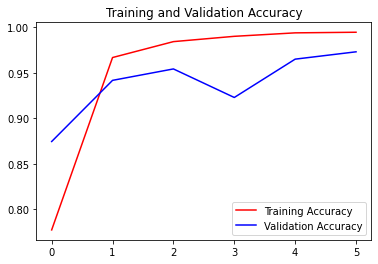

<Figure size 432x288 with 0 Axes>

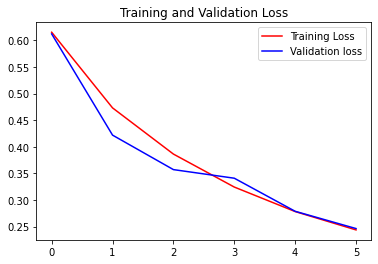

<Figure size 432x288 with 0 Axes>

In [17]:
# plotting
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

# Training and Validation Accuracy
plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

# Training and validation loss
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()